In [540]:
# !pip install easyocr

In [541]:
from transformers import AutoModelForObjectDetection
model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

In [542]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [543]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

cpu


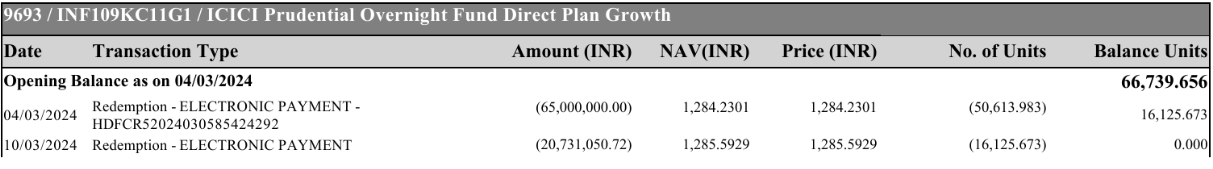

In [544]:
from PIL import Image
from huggingface_hub import hf_hub_download
# Loading an example image
file_path = "page0Table.png"
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image)

In [545]:
from torchvision import transforms
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size
    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))
        return resized_image
detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 111, 800])


In [546]:
import torch
with torch.no_grad():
  outputs = model(pixel_values)

In [547]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.51 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"
def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]
    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score), 'bbox': [float(elem) for elem in bbox]})
    return objects


In [548]:
objects = outputs_to_objects(outputs, image.size, id2label)

print(objects)

[{'label': 'table', 'score': 0.999893069267273, 'bbox': [-3.676621675491333, 39.59443664550781, 1211.42138671875, 154.55609130859375]}]


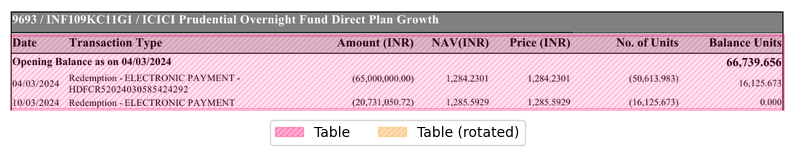

In [549]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img
def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()
    for det_table in det_tables:
        bbox = det_table['bbox']
        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth, edgecolor='none', facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth, edgecolor=edgecolor, facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0, edgecolor=edgecolor, facecolor='none', linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)
    plt.xticks([], [])
    plt.yticks([], [])
    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45), label='Table', hatch='//////', alpha=0.3),                      Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),                               label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0, fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')
    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=500)
    return fig

fig = visualize_detected_tables(image, objects)

visualized_image = fig2img(fig)

In [550]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue
        cropped_table = {}
        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]
        cropped_img = img.crop(bbox)
        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox
        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens
        table_crops.append(cropped_table)
    return table_crops

In [551]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10
tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table
cropped_table.save("table.jpg")

In [552]:
from transformers import TableTransformerForObjectDetection
# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [553]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

torch.Size([1, 3, 95, 1000])


In [554]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"
cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)
# for detection in cells:
#     detection['bbox'] = [value + 1 for value in detection['bbox']]

# for item in cells:
#     # Check if the item's label is 'table row'
#     if item['label'] == 'table row':
#         # Increment each number in the bbox by 0.1
#         item['bbox'] = [x + 1 for x in item['bbox']]





# last_table_row_index = 0
# for i in range(len(cells)):
#     if cells[i]['label'] == 'table row':
#         last_table_row_index += 1

# print(last_table_row_index)

# Iterate through each item in the list
# i = 0
# for item in cells:
#     # Check if the current index is not the last table row
#     if item['label'] == 'table row':
#       if i != last_table_row_index:
#         print(i)
#         # Increment each number in the bbox by 0.1
#         item['bbox'] = [x + 2 for x in item['bbox']]
#         i+=1
#       if i == last_table_row_index:
#         print(i)
#         # Increment each number in the bbox by 0.1
#         item['bbox'] = [x - 4 for x in item['bbox']]
#         i+=1

[{'label': 'table column', 'score': 0.9999560117721558, 'bbox': [84.16341400146484, -8.225440979003906e-05, 442.2426452636719, 114.21320343017578]}, {'label': 'table column', 'score': 0.999953031539917, 'bbox': [917.8748168945312, -0.057026296854019165, 1077.85888671875, 114.20337677001953]}, {'label': 'table column', 'score': 0.999437153339386, 'bbox': [652.5482788085938, 0.03824487328529358, 772.7561645507812, 114.17607116699219]}, {'label': 'table column', 'score': 0.9999240636825562, 'bbox': [769.974609375, 0.02938196063041687, 918.9689331054688, 114.17381286621094]}, {'label': 'table row', 'score': 0.9902403354644775, 'bbox': [-4.749063014984131, 24.89790153503418, 1214.893310546875, 54.635894775390625]}, {'label': 'table column', 'score': 0.9998891353607178, 'bbox': [1076.2999267578125, 0.011885762214660645, 1215.0242919921875, 114.40158081054688]}, {'label': 'table column header', 'score': 0.987537682056427, 'bbox': [-5.065826416015625, -0.05334198474884033, 1214.85791015625, 25

In [555]:
for detection in cells:
    print(detection['bbox'])

[84.16341400146484, -8.225440979003906e-05, 442.2426452636719, 114.21320343017578]
[917.8748168945312, -0.057026296854019165, 1077.85888671875, 114.20337677001953]
[652.5482788085938, 0.03824487328529358, 772.7561645507812, 114.17607116699219]
[769.974609375, 0.02938196063041687, 918.9689331054688, 114.17381286621094]
[-4.749063014984131, 24.89790153503418, 1214.893310546875, 54.635894775390625]
[1076.2999267578125, 0.011885762214660645, 1215.0242919921875, 114.40158081054688]
[-5.065826416015625, -0.05334198474884033, 1214.85791015625, 25.177186965942383]
[-4.515002727508545, 56.77898406982422, 1214.966796875, 87.06083679199219]
[438.3802185058594, -0.008115768432617188, 651.4532470703125, 114.28485107421875]
[-4.759274005889893, 0.00438690185546875, 1214.65673828125, 114.36809539794922]
[-4.590826034545898, 88.63252258300781, 1214.8829345703125, 114.46782684326172]
[5.939533233642578, 0.02398744225502014, 86.03350067138672, 114.50080108642578]
[-4.9697980880737305, -0.065515637397766

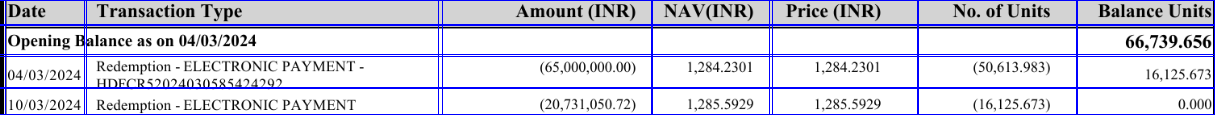

In [556]:
from PIL import ImageDraw
cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)
for cell in cells:
    draw.rectangle(cell["bbox"], outline="blue")
cropped_table_visualized

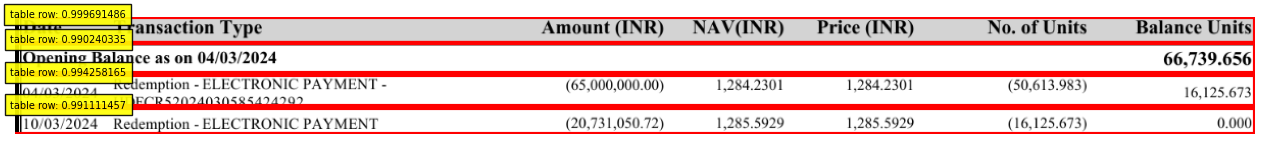

In [557]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")
    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()
    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]
        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.9f}'
          ax.text(xmin, ymin, text, fontsize=7, bbox=dict(facecolor='yellow', alpha=0.9))
          plt.axis('off')

plot_results(cells, class_to_visualize="table row")

In [558]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']
    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])
    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox
    # Generate cell coordinates and count cells in each row
    cell_coordinates = []
    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})
        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])
        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})
    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])
    return cell_coordinates
cell_coordinates = get_cell_coordinates_by_row(cells)

In [559]:
len(cell_coordinates)

4

In [560]:
len(cell_coordinates[0]["cells"])

7

In [561]:
type(cell_coordinates)

list

In [562]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [5.939533233642578, 0.02398744225502014, 86.03350067138672, 114.50080108642578], 'cell': [5.939533233642578, -0.06551563739776611, 86.03350067138672, 25.142793655395508]}, {'column': [84.16341400146484, -8.225440979003906e-05, 442.2426452636719, 114.21320343017578], 'cell': [84.16341400146484, -0.06551563739776611, 442.2426452636719, 25.142793655395508]}, {'column': [438.3802185058594, -0.008115768432617188, 651.4532470703125, 114.28485107421875], 'cell': [438.3802185058594, -0.06551563739776611, 651.4532470703125, 25.142793655395508]}, {'column': [652.5482788085938, 0.03824487328529358, 772.7561645507812, 114.17607116699219], 'cell': [652.5482788085938, -0.06551563739776611, 772.7561645507812, 25.142793655395508]}, {'column': [769.974609375, 0.02938196063041687, 918.9689331054688, 114.17381286621094], 'cell': [769.974609375, -0.06551563739776611, 918.9689331054688, 25.142793655395508]}, {'column': [917.8748168945312, -0.057026296854019165, 1077.85888671875, 114.20337677001

In [563]:
for row in cell_coordinates:
  print(row)

{'row': [-4.9697980880737305, -0.06551563739776611, 1214.944580078125, 25.142793655395508], 'cells': [{'column': [5.939533233642578, 0.02398744225502014, 86.03350067138672, 114.50080108642578], 'cell': [5.939533233642578, -0.06551563739776611, 86.03350067138672, 25.142793655395508]}, {'column': [84.16341400146484, -8.225440979003906e-05, 442.2426452636719, 114.21320343017578], 'cell': [84.16341400146484, -0.06551563739776611, 442.2426452636719, 25.142793655395508]}, {'column': [438.3802185058594, -0.008115768432617188, 651.4532470703125, 114.28485107421875], 'cell': [438.3802185058594, -0.06551563739776611, 651.4532470703125, 25.142793655395508]}, {'column': [652.5482788085938, 0.03824487328529358, 772.7561645507812, 114.17607116699219], 'cell': [652.5482788085938, -0.06551563739776611, 772.7561645507812, 25.142793655395508]}, {'column': [769.974609375, 0.02938196063041687, 918.9689331054688, 114.17381286621094], 'cell': [769.974609375, -0.06551563739776611, 918.9689331054688, 25.14279

In [564]:
def increment_values(nums):
    return [x + 2.1 if isinstance(x, (int, float)) else x for x in nums]

# Iterate through each dictionary in the list
for item in cell_coordinates[:-1]:
    # Update the 'row' values
    item['row'] = increment_values(item['row'])

    # Iterate through each cell in the 'cells' list
    for cell in item['cells']:
        # Update the 'column' values
        cell['column'] = increment_values(cell['column'])
        # Update the 'cell' values
        cell['cell'] = increment_values(cell['cell'])


for row in cell_coordinates:
  print(row)

{'row': [-2.8697980880737304, 2.034484362602234, 1217.044580078125, 27.24279365539551], 'cells': [{'column': [8.039533233642578, 2.1239874422550202, 88.13350067138671, 116.60080108642578], 'cell': [8.039533233642578, 2.034484362602234, 88.13350067138671, 27.24279365539551]}, {'column': [86.26341400146484, 2.09991774559021, 444.3426452636719, 116.31320343017578], 'cell': [86.26341400146484, 2.034484362602234, 444.3426452636719, 27.24279365539551]}, {'column': [440.4802185058594, 2.091884231567383, 653.5532470703125, 116.38485107421874], 'cell': [440.4802185058594, 2.034484362602234, 653.5532470703125, 27.24279365539551]}, {'column': [654.6482788085938, 2.1382448732852937, 774.8561645507813, 116.27607116699218], 'cell': [654.6482788085938, 2.034484362602234, 774.8561645507813, 27.24279365539551]}, {'column': [772.074609375, 2.129381960630417, 921.0689331054688, 116.27381286621093], 'cell': [772.074609375, 2.034484362602234, 921.0689331054688, 27.24279365539551]}, {'column': [919.97481689

In [565]:
# import numpy as np
# import csv
# import easyocr
# from tqdm.auto import tqdm
# reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
# def apply_ocr(cell_coordinates):
#     # let's OCR row by row
#     data = dict()
#     max_num_columns = 0
#     for idx, row in enumerate(tqdm(cell_coordinates)):
#       row_text = []
#       for cell in row["cells"]:
#         # crop cell out of image
#         cell_image = np.array(cropped_table.crop(cell["cell"]))
#         # apply OCR
#         result = reader.readtext(np.array(cell_image))
#         if len(result) > 0:
#           # print([x[1] for x in list(result)])
#           text = " ".join([x[1] for x in result])
#           row_text.append(text)


#       if len(row_text) > max_num_columns:
#           max_num_columns = len(row_text)
#       data[idx] = row_text
#     print("Max number of columns:", max_num_columns)


#     # pad rows which don't have max_num_columns elements
#     # to make sure all rows have the same number of columns
#     for row, row_data in data.copy().items():
#         if len(row_data) != max_num_columns:
#           row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
#         data[row] = row_data
#     return data
# data = apply_ocr(cell_coordinates)
# for row, row_data in data.items():
#     print(row_data)

In [566]:
# !sudo apt install tesseract-ocr
# !pip install pytesseract

In [567]:
import numpy as np
import pytesseract
from PIL import Image
from tqdm.auto import tqdm
import cv2
from google.colab.patches import cv2_imshow

# Function to apply OCR to the cells of a table
def apply_ocr(cell_coordinates, cropped_table):
    # Initialize data storage and find the maximum number of columns
    data = {}
    max_num_columns = 0

    # Process each row of cells
    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # Crop the cell from the table image
            left, top, right, bottom = cell["cell"]
            cell_image = cropped_table.crop((left, top, right, bottom))

            # Convert PIL image to OpenCV format for better compatibility with pytesseract
            open_cv_image = np.array(cell_image)
            open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)

            # Apply OCR to extract text
            text = pytesseract.image_to_string(open_cv_image, lang='eng')

            # Clean and store the extracted text
            cleaned_text = text.strip().replace('\n', ' ')
            row_text.append(cleaned_text)

        # Update maximum number of columns found
        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)
        data[idx] = row_text

    # Pad rows to ensure all have the same number of columns
    for key, value in data.items():
        if len(value) < max_num_columns:
            value.extend([""] * (max_num_columns - len(value)))
            data[key] = value

    return data

# Assuming cropped_table is a PIL Image and cell_coordinates is structured appropriately
# Example cell_coordinates format:
# cell_coordinates = [{'cells': [{'cell': (x1, y1, x2, y2)}, ...]}, ...]

# Use the function
data = apply_ocr(cell_coordinates, cropped_table)
for row in data.values():
    print(row)


  0%|          | 0/4 [00:00<?, ?it/s]

['Date', 'Transaction Type', 'Amount (INR)', '', 'Price (INR)', 'No. of Units', 'Balance Units}']
['', 'alance as on 04/03/2024', '', '', '', '', '']
['04/03/2024', 'Redemption - ELECTRONIC PAYMENT - HDFCRS2024030585424292', '(65,000,000.00)', '1,284.2301', '1,284.2301', '(50,613.983)', '16,125.673]']
['10/03/2024', 'Redemption - ELECTRONIC PAYMENT', '(20,731,050.72)', '1,285.5929', '1,285.5929', '(16,125.673)', '0.000]']
